# 2.Caffe2 的一些基本概念 - Workspaces&Operators & Nets & Nets 可视化

这个部分我们将介绍一些基本概念，这包括： 怎样写 operators 和 nets 

首先，让我们 import Caffe2. `core` 和 `workspace` 。如果你想查看Caffe2生成的  protocol buffers 文件 , 那么应该 
import `caffe2_pb2` from `caffe2.proto`.

In [72]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# We'll also import a few standard python libraries
from matplotlib import pyplot
import numpy as np
import time

# These are the droids you are looking for.
from caffe2.python import core, workspace
from caffe2.proto import caffe2_pb2

# Let's show all plots inline.
%matplotlib inline

您可能会看到一条警告，说caffe2没有GPU支持。这意味着您正在运行CPU的caffe2。不要惊慌，CPU仍然可以运行。

## 1.Workspaces

让我们首先介绍所有数据所在的工作空间Workspaces。

与Matlab类似，caff2工作区由您创建并存储在内存中的blob组成。现在，假设一个blob是一个n维张量（Tensor），类似于numpy的ndarray，但是是连续的。接下来，我们将向您展示blob实际上是一个可以存储任何类型的c++对象的类型化指针，但是张量（Tensor）仅仅是存储在blob中的最常见类型。让我们看看交互是什么样的。

`Blobs()` prints out all existing blobs in the workspace. 

`HasBlob()` queries if a blob exists in the workspace. As of now, we don't have any.

In [73]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))

Current blobs in the workspace: [u'W', u'X', u'Y', u'b']
Workspace has blob 'X'? True


我们可以使用`FeedBlob()`将 blobs 放进 workspace 中:

In [74]:
X = np.random.randn(2, 3).astype(np.float32)
print("Generated X from numpy:\n{}".format(X))
workspace.FeedBlob("X", X)

Generated X from numpy:
[[-0.02584119  1.2813169   0.49287322]
 [ 1.8800957  -1.1769409   0.12025763]]


True

现在，让我们看看在 workspace存了什么 blobs .

In [75]:
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
print("Workspace has blob 'X'? {}".format(workspace.HasBlob("X")))
print("Fetched X:\n{}".format(workspace.FetchBlob("X")))

Current blobs in the workspace: [u'W', u'X', u'Y', u'b']
Workspace has blob 'X'? True
Fetched X:
[[-0.02584119  1.2813169   0.49287322]
 [ 1.8800957  -1.1769409   0.12025763]]


我们可以看到这就是我们刚才存进去的数据:

In [76]:
np.testing.assert_array_equal(X, workspace.FetchBlob("X"))

注意：如果我们想要从workspace中取出一个不存在的blob比如”invincible_pink_unicorn“，那么会报错：

In [77]:
try:
    workspace.FetchBlob("invincible_pink_unicorn")
except RuntimeError as err:
    print(err)

[enforce fail at pybind_state.cc:175] ws->HasBlob(name). Can't find blob: invincible_pink_unicorn



您可能现在不会立即使用的一件事：您可以使用不同的名称在Python中拥有多个工作空间（Workspace），并在它们之间切换。不同工作空间（Workspace）中的Blob彼此分开。您可以使用`CurrentWorkspace`查询当前工作空间（Workspace）。让我们尝试按名称（例如：gutentag）切换工作区，如果不存在则创建一个新工作区。

In [78]:
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

# Switch the workspace. The second argument "True" means creating 
# the workspace if it is missing.
workspace.SwitchWorkspace("gutentag", True)

# Let's print the current workspace. Note that there is nothing in the
# workspace yet.
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'W', u'X', u'Y', u'b']
Current workspace: gutentag
Current blobs in the workspace: []


让我们选回默认工作空间（Workspace）：

In [79]:
workspace.SwitchWorkspace("default")
print("Current workspace: {}".format(workspace.CurrentWorkspace()))
print("Current blobs in the workspace: {}".format(workspace.Blobs()))

Current workspace: default
Current blobs in the workspace: [u'W', u'X', u'Y', u'b']


最后，`ResetWorkspace()`命令清除当前工作空间中的所有内容：

In [80]:
workspace.ResetWorkspace()
print("Current blobs in the workspace after reset: {}".format(workspace.Blobs()))

Current blobs in the workspace after reset: []


## 2.Operators

Caffe2中的Operators是一种类似于函数的形式。 从C++的角度来看，它们都来自通用接口并按类型注册，因此我们可以在运行时调用不同的Operators。Operators的接口在`caffe2 / proto / caffe2.proto`中定义。 基本上，它需要一些输入并产生一些输出。

切记，当我们在caffe2 Python 中 使用"create an operator"函数时，仅仅是新建了一个protocol buffer 并定义上相应的operators。之后，当我们执行的时候才会送到c++ 后端去执行。

让我们看一个例子：


In [81]:
# Create an operator.
op = core.CreateOperator(
    "Relu", # The type of operator that we want to run
    ["X"], # A list of input blobs by their names
    ["Y"], # A list of output blobs by their names
)
# and we are done!

正如我们提到的，创建的op实际上是一个protobuf对象。让我们来看看内容：

In [82]:
print("Type of the created op is: {}".format(type(op)))
print("Content:\n")
print(str(op))

Type of the created op is: <class 'caffe2.proto.caffe2_pb2.OperatorDef'>
Content:

input: "X"
output: "Y"
name: ""
type: "Relu"




好的，让我们运行（run）operator。我们首先将输入X提供给工作空间（Workspace）。然后运行运算符（run operator）的最简单方法是执行workspace.RunOperatorOnce（operator）


In [83]:
workspace.FeedBlob("X", np.random.randn(2, 3).astype(np.float32))
workspace.RunOperatorOnce(op)

True


执行（execution）后，让我们看看（operator）做了什么事情？

这次我们定义的（operator）是神经网络中使用的常见激活函数，称为[ReLU]（https://en.wikipedia.org/wiki/Rectifier/neural_networks） 
，全称是（Rectified Linear Unit activation）整流线性激活单元.ReLU激活有助于添加神经网络分类器必要的非线性特征，定义如下：
$$ReLU(x) = max(0, x)$$

In [84]:
print("Current blobs in the workspace: {}\n".format(workspace.Blobs()))
print("X:\n{}\n".format(workspace.FetchBlob("X")))
print("Y:\n{}\n".format(workspace.FetchBlob("Y")))
print("Expected:\n{}\n".format(np.maximum(workspace.FetchBlob("X"), 0)))

Current blobs in the workspace: [u'X', u'Y']

X:
[[ 1.1209662   0.8112169  -1.5429683 ]
 [-1.1201754   0.46254316 -0.10579768]]

Y:
[[1.1209662  0.8112169  0.        ]
 [0.         0.46254316 0.        ]]

Expected:
[[1.1209662  0.8112169  0.        ]
 [0.         0.46254316 0.        ]]



从上边的例子可以验证该函数与公式相符。

 如果需要，运算符（Operators）也可以使用可选参数。它们被指定为键值对（key-value pairs）。让我们看一个简单的例子，它采用张量（Tensor）并用高斯随机变量填充它。


In [85]:
op = core.CreateOperator(
    "GaussianFill",# The type of operator that we want to run
    [], # GaussianFill does not need any parameters.   # A list of input blobs by their names
    ["Z"],# A list of output blobs by their names
    shape=[100, 100], # shape argument as a list of ints.
    mean=1.0,  # mean as a single float
    std=1.0, # std as a single float
)
print("Content of op:\n")
print(str(op))

Content of op:

output: "Z"
name: ""
type: "GaussianFill"
arg {
  name: "std"
  f: 1.0
}
arg {
  name: "shape"
  ints: 100
  ints: 100
}
arg {
  name: "mean"
  f: 1.0
}



让我们运行一下，看一下结果：

Text(0.5,1,u'Distribution of Z')

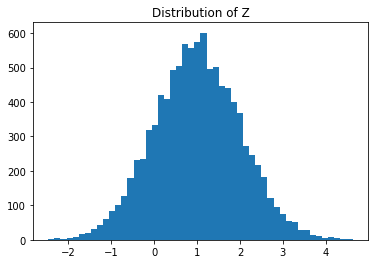

In [86]:
workspace.RunOperatorOnce(op)
temp = workspace.FetchBlob("Z")
pyplot.hist(temp.flatten(), bins=50)
pyplot.title("Distribution of Z")

如果你看到一个钟形曲线，那么它的工作原理！

## 3.Nets

网络(Nets)本质上是计算图。我们将名称“Net”保持为向后一致性（并且还向神经网络致敬）。网络由多个运算符(operators)组成，就像编写为一系列命令的程序一样。让我们来看看。


当我们谈论网络(nets)时，我们还将讨论BlobReference，它是一个包裹字符串的对象，因此我们可以轻松地对运算符(operators)进行链接。

让我们创建一个基本上等同于以下python数学的网络：
```
X = np.random.randn(2, 3)
W = np.random.randn(5, 3)
b = np.ones(5)
Y = X * W^T + b
```
我们将逐步展示进展。 Caffe2的`core.Net`是围绕NetDef协议缓冲区的包装类(wrapper class)。

创建网络时，除了网络名称之外，其底层协议缓冲区基本上是空的。让我们创建网络（net），然后显示原型内容（proto content）。

In [87]:
my_net = core.Net("my_first_net")
print("Current network proto:\n\n{}".format(net.Proto()))

Current network proto:

name: "my_first_net_3"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



让我们创建一个名为X的blob，并使用GaussianFill用一些随机数据填充它。

In [88]:
X = my_net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
print("New network proto:\n\n{}".format(net.Proto()))

New network proto:

name: "my_first_net_3"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



您可能已经观察到与之前的`core.CreateOperator`调用有一些差异。基本上，当使用网络(net)时，您可以直接创建一个运算符(operator)并通过调用`net.SomeOp`将其添加到网络中，其中SomeOp是运算符的注册类型字符串(a registered type string of an operator)。下面两行是等价的：
```
op = core.CreateOperator(
    "GaussianFill",
    [],
    ["X"],
    shape=[2, 3], 
    mean=0.0,  
    std=1.0,
    run_once=0
)
net.Proto().op.append(op)
```
等价与：
```
X = net.GaussianFill([], ["X"], mean=0.0, std=1.0, shape=[2, 3], run_once=0)
```

此外，您可能想知道X是什么。 X是一个`BlobReference`，它记录了两件事：

- blob的名称，用`str（X）`访问

- 它所在的的网络，由内部变量`_from_net`记录

我们来核实一下吧。另外，请记住，我们实际上并没有运行任何东西，所以X只包含一个符号。不要指望现在得到任何数值:)

In [89]:
print("Type of X is: {}".format(type(X)))
print("The blob name is: {}".format(str(X)))

Type of X is: <class 'caffe2.python.core.BlobReference'>
The blob name is: X


让我们继续创建 W and b.

In [90]:
W = my_net.GaussianFill([], ["W"], mean=0.0, std=1.0, shape=[5, 3], run_once=0)
b = my_net.ConstantFill([], ["b"], shape=[5,], value=1.0, run_once=0)

现在，一个简单的代码糖：由于BlobReference对象知道它是从哪个网络生成的，除了从net创建运算符（operators）之外，您还可以从BlobReferences创建运算符（operators）。让我们以这种方式创建FC运算符（operators）。

In [91]:
Y = X.FC([W, b], ["Y"])

在引擎盖(hood)下，`X.FC（...）`通过插入`X`作为相应运算符的第一个输入来简单地委托给`net.FC`，所以我们上面所做的相当于:
```
Y = net.FC([X, W, b], ["Y"])
```

让我们看一下当前（net）：

In [92]:
print("Current network proto:\n\n{}".format(my_net.Proto()))

Current network proto:

name: "my_first_net_5"
op {
  output: "X"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 2
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "W"
  name: ""
  type: "GaussianFill"
  arg {
    name: "std"
    f: 1.0
  }
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
    ints: 3
  }
  arg {
    name: "mean"
    f: 0.0
  }
}
op {
  output: "b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "run_once"
    i: 0
  }
  arg {
    name: "shape"
    ints: 5
  }
  arg {
    name: "value"
    f: 1.0
  }
}
op {
  input: "X"
  input: "W"
  input: "b"
  output: "Y"
  name: ""
  type: "FC"
}



太冗长了吧？让我们尝试将其可视化为图形。为此，Caffe2附带了一个非常小的图形可视化工具

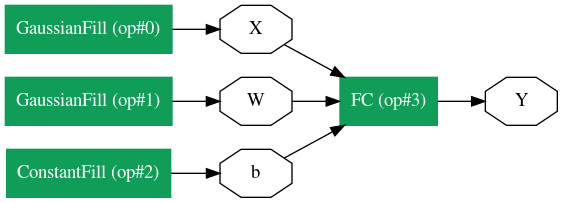

In [93]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(my_net, rankdir="LR")
display.Image(graph.create_png(), width=800)

所以我们已经定义了一个网络，但还没有执行任何内容。请记住，上面的网络本质上是一个保存网络定义的protobuf。当我们真正运行网络时，幕后发生的事情是
- 从protobuf中实例化一个 C++ net object
- 调用实例化的net的Run（）函数

在我们做任何事情之前，我们应该使用`ResetWorkspace（）`清除任何早期的工作区变量。

然后有两种方法可以从Python运行网络。我们将在下面的示例中首先执行第一个选项。

1.调用`workspace.RunNetOnce（）`，它实例化，运行并立即拆分网络    
2.调用`workspace.CreateNet（）`来创建工作空间(workspace)所拥有的C++net对象，然后调用workspace.RunNet()，将网络的名称传递给它。

In [94]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.RunNetOnce(my_net)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
# Let's dump the contents of the blobs
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[-0.5135348  -1.6074936  -0.85531217]
 [ 0.55833554  0.55954295 -1.3781272 ]
 [-0.991518   -0.49916956  1.3225383 ]
 [ 0.84439176  0.07618229 -0.62683123]
 [-0.602707   -0.65742415  0.66565436]]
X:
[[-0.62176234  0.63317245  0.8652356 ]
 [-1.5274166  -0.09956307 -0.00647647]]
Y:
[[-0.43857074 -0.1852696   2.4447355  -0.01913118  1.5344255 ]
 [ 1.949968    0.10040456  2.5555944  -0.2932632   1.9817288 ]]
b:
[1. 1. 1. 1. 1.]


现在让我们尝试第二种方法来创建网络（net）并运行它。首先，使用`ResetWorkspace（）`清除变量。然后使用我们之前使用`CreateNet（net_object）`创建的工作空间（workspace）的`net`对象创建网络(my_net)。最后，使用`RunNet（net_name）`运行网络。

In [95]:
workspace.ResetWorkspace()
print("Current blobs in the workspace: {}".format(workspace.Blobs()))
workspace.CreateNet(my_net)
workspace.RunNet(my_net.Proto().name)
print("Blobs in the workspace after execution: {}".format(workspace.Blobs()))
for name in workspace.Blobs():
    print("{}:\n{}".format(name, workspace.FetchBlob(name)))

Current blobs in the workspace: []
Blobs in the workspace after execution: [u'W', u'X', u'Y', u'b']
W:
[[ 1.9866093e-03  6.1452633e-01  2.6723117e-01]
 [-3.7205499e-01 -1.6160715e+00 -1.4222487e+00]
 [ 1.1416672e+00  8.5878557e-01 -3.5418496e-01]
 [ 3.9810416e-01  1.7708173e-01  8.4679842e-01]
 [ 2.3121457e+00  3.7234628e-01 -1.5822794e-01]]
X:
[[-0.97019637  2.3577101   0.49893522]
 [ 0.78800434 -0.21854126  0.18668541]]
Y:
[[ 2.5802786  -3.1588717   1.7404106   1.4537657  -0.44429624]
 [ 0.91715425  0.79448426  1.6458375   1.4330931   2.711069  ]]
b:
[1. 1. 1. 1. 1.]


`RunNetOnce`和`RunNet`之间存在一些差异，但主要区别在于计算开销。由于`RunNetOnce`涉及序列化protobuf以在Python和C之间传递并实例化网络，因此运行可能需要更长时间。让我们进行测试，看看时间开销是多少。

In [96]:
# It seems that %timeit magic does not work well with
# C++ extensions so we'll basically do for loops
start = time.time()
for i in range(1000):
    workspace.RunNetOnce(my_net)
end = time.time()
print('Run time per RunNetOnce: {}'.format((end - start) / 1000))

start = time.time()
for i in range(1000):
    workspace.RunNet(my_net.Proto().name)
end = time.time()
print('Run time per RunNet: {}'.format((end - start) / 1000))

Run time per RunNetOnce: 0.000457355976105
Run time per RunNet: 1.52060985565e-05


恭喜，您现在已经了解了Caffe2 Python API的许多关键组件！准备好了解更多Caffe2？查看其余的教程，了解各种有趣的用例！